# This should solve your problem

In [46]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
%matplotlib inline

# uncomment this line to install seaborn
# !pip install seaborn
import seaborn as sns
sns.set()

np.random.seed(42)

# choose how many clusters (sets of data jsons?)
num_clusters = 1000


# date range from 2018-01-01 00:00:00 to 2018-01-08 00:00:00
# only generating possible cluster times over this range

date_parser = '%Y-%m-%d %X'

start = datetime.strptime('2018-01-01 00:00:00', date_parser)
end = datetime.strptime('2018-01-10 00:00:01', date_parser)

possible_dates = pd.date_range(start,end, freq='T') # 'T' for minutes, 's' for seconds

dataframes = [pd.DataFrame({'':[np.nan]*len(possible_dates) },index=possible_dates )]

def make_random_job_df():
    """Creates fake cluster load data, appends to dataframes list"""
    
    # go from 20 minutes all the way up to the length of the whole time period
    timelength = np.random.randint(20, int((end-start).total_seconds()/60))
    
    # randomly choose a start_time and end_time
    # add extra dates to the beginning to make distribution more accurate
    start_time = pd.to_datetime( np.random.choice(possible_dates - timedelta(hours=72)) )
    end_time = start_time + timedelta(minutes = timelength)
    
    # generate the datetime range for dataframe
    date_range = pd.date_range(start_time, end_time, freq='T')
    
    # generate cluster is active or inactive
    # 5% chance to be inactive 
    # 95% chance to be active
    cluster_active = np.random.choice([0,1], p=[.3,.7], size=timelength+1)
    
    # create dataframe and add to list of dataframes
    df = pd.DataFrame({'cluster':cluster_active},index=date_range)    
    dataframes.append(df)
    
# generate the data
for n in range(num_clusters):
    make_random_job_df()

# rename columns
dfcolumns = ['cluster_{}'.format(i+1) for i in range(len(dataframes))]

# combine all the dataframes together
total_df = pd.concat(dataframes, axis=1)
total_df.columns = dfcolumns

# drop the first dataframe (only used to get dataframe to include all datetimes)
total_df.drop(total_df.columns[0],axis=1,inplace=True)

# get rid of nans from concat of dfs
total_df = total_df.fillna(value=0)

# only keep times in our range
total_df = total_df.loc[start:end]

# adding everything in each column (all individual clusters together)
total_df['total_jobs_running'] = total_df.sum(axis=1)

# Making some plots

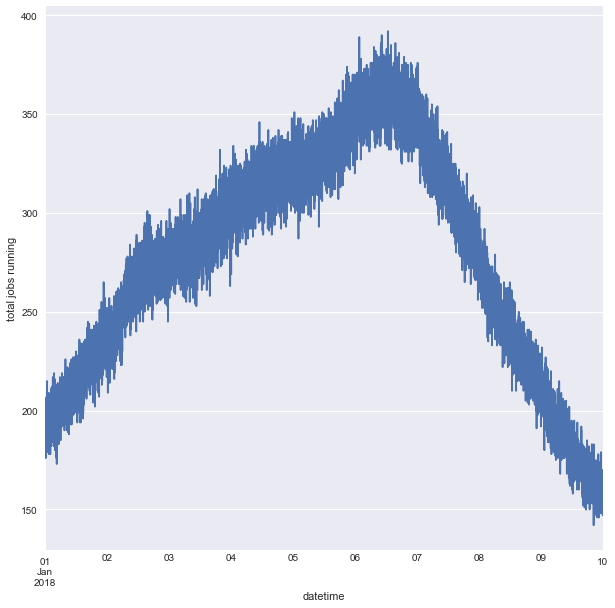

In [47]:
# show the plot if you want, its as large as the number of clusters created
def show_plot():
    """plot of each cluster individually as well as them all together"""
    f, ax = plt.subplots(num_clusters+1,1,sharex=True,figsize=(20,5*num_clusters))
    for idx, cluster in enumerate(total_df):
        ax[idx].plot(total_df.index, total_df[cluster], label='cluster {}'.format(idx))



    ax[-1].plot(total_df['total_jobs_running'])

    plt.legend(loc='best')
    plt.show()
    

total_df['total_jobs_running'].plot(kind='line',figsize=(10,10))
plt.xlabel('datetime')
plt.ylabel('total jobs running')
plt.show()

# The holy grail

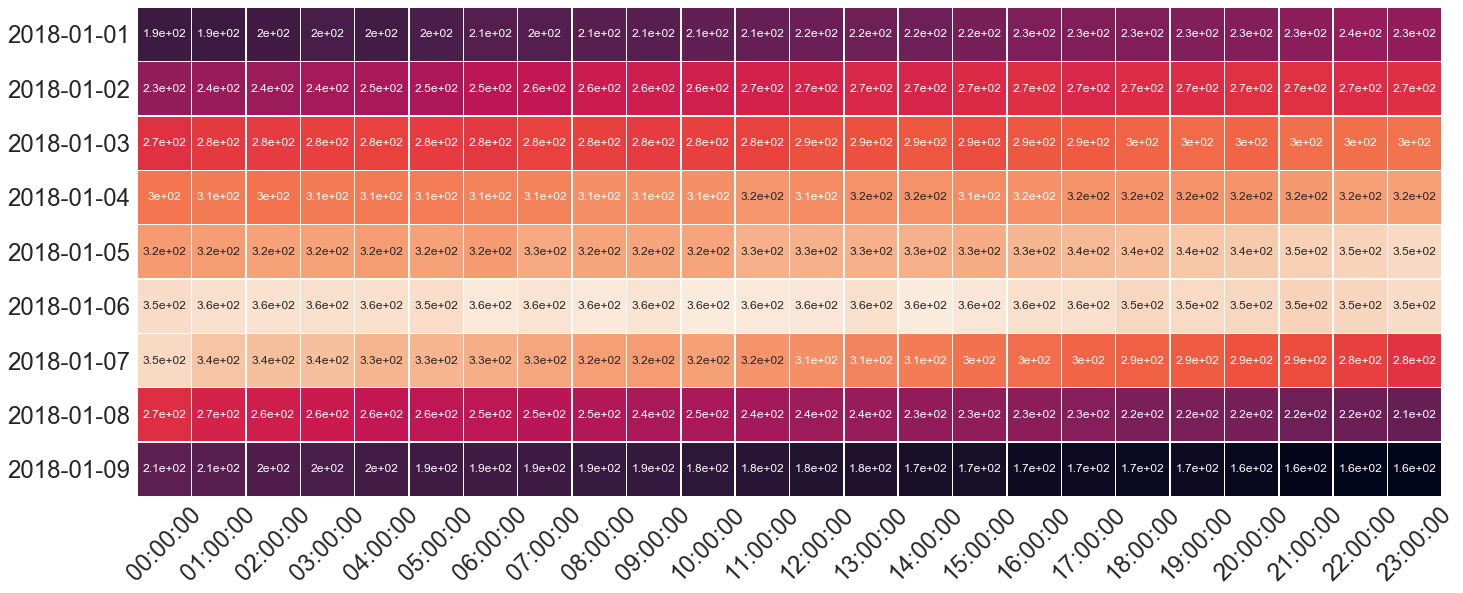

In [48]:
# only grab total jobs running but as a dataframe
total_jobs_df = total_df[['total_jobs_running']]

# grab the total_jobs, group by 'H' (hour), sum, divide by 60 mins/hr
total_server_load = total_jobs_df[:-1].resample('H').sum()/60

# reshape it into [days,hours] provided you have entire days
# if you initiallize your dataframes list as I did with a 
# basically empty df, it should force your shape to satisify this
# condition if you make start and end happen at 00:00:00 on some day
total_server_load = total_server_load.values.reshape(-1,24)

# fixing some indexing
max_day = end.date() - timedelta(hours=1)

# getting the days to label the heatmap
possible_dates = pd.date_range(start.date() ,max_day, freq='D')[:-1]
# getting rid of the times
possible_dates = [x.strftime('%Y-%m-%d') for x in possible_dates]

# getting the hours to label the heatmap
possible_times = pd.date_range(datetime(2018,1,1,0,0,0), datetime(2018,1,1,23,0,0), freq='H')
# getting rid of the dates
possible_times = [x.strftime('%H:%M:%S')[:8] for x in possible_times]

# turn our reshaped array back into a pandas datafram
total_server_load = pd.DataFrame(total_server_load)

# relabel our cols/index so heatmap labels the ticks correctly
total_server_load.columns = possible_times
total_server_load.index = possible_dates


plt.figure(figsize=(24,len(possible_dates)))
plt.axes().set_aspect('equal')
plt.margins(0.02)
ax = sns.heatmap(total_server_load, annot=True, 
                 linewidths=.5,cbar=False)
ax.set_yticklabels(possible_dates, rotation=0,fontsize=24)
ax.set_xticklabels(possible_times, rotation=45 ,fontsize=24)
plt.show()